# Programming Assignment 1 - A

I code it with pure python (without library) except visualization of dendogram

In [1]:
import os
import math
import re

In [2]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text.strip()

In [3]:
basepath = './aclImdb'
def read_corpus():
    for s in ('test', 'train'):
        for l in ('pos', 'neg'):
            path = os.path.join(basepath, s, l)
            for file in os.listdir(path):
                with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                    yield preprocessor(infile.read())

In [4]:
w2w_vec = dict()
w_vec = dict()
nneighbors = 10

In [5]:
for text in read_corpus():
    words = text.split()
    for wi in range(len(words)):
        w_vec[words[wi]] = w_vec.get(words[wi], 0) + 1
        for i in range(wi + 1, wi + 1 + nneighbors):
            if len(words) > i:
                w_pair = (words[wi], words[i])
                w2w_vec[w_pair] = w2w_vec.get(w_pair, 0) + 1 
        for i in range(wi - nneighbors, wi):
            if i >= 0:
                w_pair = (words[wi], words[i])
                w2w_vec[w_pair] = w2w_vec.get(w_pair, 0) + 1

In [6]:
def pmi_scoring(w1, w2):
    score = w2w_vec[(w1,w2)] / (w_vec[w1] * w_vec[w2])
    return math.log2(score + 0.1e-3)

In [7]:
def ppmi_scoring(w1,w2):
    return max(pmi_scoring(w1,w2), 0)

In [8]:
ppmi_vec = dict()
for w1, w2 in w2w_vec:
    score = ppmi_scoring(w1,w2)
    if score:
        if w1 not in ppmi_vec:
            ppmi_vec[w1] = dict()
        ppmi_vec[w1][w2] = score    

PCA not helping ;thus, I added but do not used

In [39]:
from numpy.linalg import svd
from pandas import DataFrame

df = DataFrame(ppmi_vec).T.fillna(0)
U, s, V = svd(df.as_matrix(), full_matrices=True)

In [9]:
def cos_similarity(w1,w2):
    dot_w1_w2 = 0
    for w_other in ppmi_vec[w1]:
        if w_other in ppmi_vec[w2]:
            dot_w1_w2 += ppmi_vec[w1][w_other] * ppmi_vec[w2][w_other]
    vec_len_w1 = math.sqrt(sum([v**2 for v in ppmi_vec[w1].values()]))
    vec_len_w2 = math.sqrt(sum([v**2 for v in ppmi_vec[w2].values()]))
    return dot_w1_w2 / (vec_len_w1 * vec_len_w2)

In [10]:
len(ppmi_vec)

9375

In [11]:
sim_w = dict()
for w1 in ppmi_vec:
    for w2 in ppmi_vec:
        if w1 == w2:
            continue
        sim = cos_similarity(w1, w2)
        if sim: 
             sim_w[(w1,w2)] = sim

In [16]:
len(sim_w)

7028

In [12]:
def most_similar_by_word(word):
    return list(filter(lambda x: x[0][0] == word , sim_w.items()))

Dataset contains range of language. I only interested with turkish and english. Those are my selection.

In [50]:
word_by_subj = list()

### Artist

In [51]:
msbw = most_similar_by_word('muslum')
word_by_subj.append('muslum')
word_by_subj.extend(map(lambda x: x[0][1], msbw))
msbw

[(('muslum', 'ferdi'), 0.8750000000000001),
 (('muslum', 'muren'), 0.8017837257372732),
 (('muslum', 'tatlises'), 0.8750000000000001),
 (('muslum', 'ajda'), 0.8750000000000001),
 (('muslum', 'pekkan'), 0.8750000000000001),
 (('muslum', 'ozbegen'), 0.8017837257372732),
 (('muslum', 'gurses'), 0.8750000000000001),
 (('muslum', 'teoman'), 0.8750000000000001)]

### Kira

In [52]:
most_similar_by_word('kirayi')

[(('kirayi', 'istemiyorum'), 0.40824829046386296),
 (('kirayi', 'calismasam'), 0.40824829046386296),
 (('kirayi', 'odeyecek'), 0.5)]

### Scinetists

In [53]:
msbw = most_similar_by_word('newtonian')
word_by_subj.append('newtonian')
word_by_subj.extend(map(lambda x: x[0][1], msbw))
msbw

[(('newtonian', 'gallilean'), 0.5), (('newtonian', 'expores'), 0.5)]

### Arteology

In [54]:
msbw = most_similar_by_word('hieroglyphic')
word_by_subj.append('hieroglyphic')
word_by_subj.extend(map(lambda x: x[0][1], msbw))
msbw

[(('hieroglyphic', 'phoenicians'), 0.5),
 (('hieroglyphic', 'inscriptions'), 0.5)]

### Religion

In [55]:
msbw = most_similar_by_word('surplice')
word_by_subj.append('surplice')
word_by_subj.extend(map(lambda x: x[0][1], msbw))
msbw

[(('surplice', 'alb'), 0.40824829046386296),
 (('surplice', 'chasuble'), 0.40824829046386296)]

In [56]:
word_by_subj

['muslum',
 'ferdi',
 'muren',
 'tatlises',
 'ajda',
 'pekkan',
 'ozbegen',
 'gurses',
 'teoman',
 'newtonian',
 'gallilean',
 'expores',
 'hieroglyphic',
 'phoenicians',
 'inscriptions',
 'surplice',
 'alb',
 'chasuble']

In [104]:
sim_word_by_subj = [
    (i,j, cos_similarity(word_by_subj[i],word_by_subj[j])) 
    for i in range(len(word_by_subj) - 1) 
    for j in range(i + 1, len(word_by_subj)) 
]

In [105]:
from scipy.sparse import csr_matrix
row, col, data = zip(*sim_word_by_subj)
dist_mat = 1 - csr_matrix((data, (row, col))).toarray()

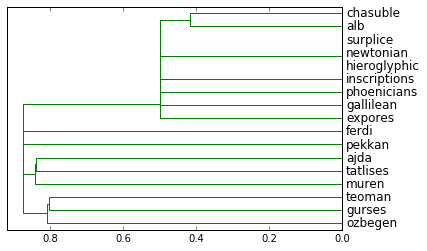

In [117]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from pandas import DataFrame

%matplotlib inline
dendrogram(linkage(dist_mat, "single"),
           color_threshold=1,
           orientation="left",
           labels=word_by_subj)
%clear